In [1]:
# For commands
import os
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
# For array manipulation
import numpy as np
import pandas as pd
import pandas.util.testing as tm
# For visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cv2
import imageio as io
from pylab import *
from sklearn.manifold import TSNE
#For model performance
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import joblib
#For model training
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from PIL import Image

In [2]:
file_path = os.listdir('dataset\img')
print(len(file_path))
train_files, test_files = train_test_split(file_path, test_size = 0.15)
print(len(train_files))
print(len(test_files))

train_files = pd.DataFrame(train_files,columns=['filepath'])
test_files = pd.DataFrame(test_files,columns=['filepath'])
#converting into .csv file for future reference.
train_files.to_csv('train_file.csv')
test_files.to_csv('test_file.csv')

963
818
145


In [3]:
#loading csv files. 
train_files = list(pd.read_csv('train_file.csv')['filepath'])
test_files = list(pd.read_csv('test_file.csv')['filepath'])

In [4]:
def image2array(file_array):

    """
    Reading and Converting images into numpy array by taking path of images.
    Arguments:
    file_array - (list) - list of file(path) names
    Returns:
    A numpy array of images. (np.ndarray)
    """

    image_array = []
    for path in tqdm(file_array):
        img = np.array(Image.open("dataset/img/" + path).convert('L'))
        # img = cv2.cvtColor(img, cv2.COLOR_)
        img = cv2.resize(img, (224,224))
        img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
        img = 255 - np.array(img)
        kernel = np.ones((5, 5), np.uint8)
        img = cv2.dilate(img, kernel)
        

        # img  = (img > 10) * 255
        image_array.append(np.array(img))
        
    image_array = np.array(image_array)
    image_array = image_array.reshape(image_array.shape[0], 224, 224, 1) 
    image_array = image_array.astype('float32')
    image_array /= 255 
    return np.array(image_array)

In [5]:
train_data = image2array(train_files)
print("Length of training dataset:",train_data.shape)
test_data = image2array(test_files)
print("Length of test dataset:",test_data.shape)

  0%|          | 0/818 [00:00<?, ?it/s]

Length of training dataset: (818, 224, 224, 1)


  0%|          | 0/145 [00:00<?, ?it/s]

Length of test dataset: (145, 224, 224, 1)


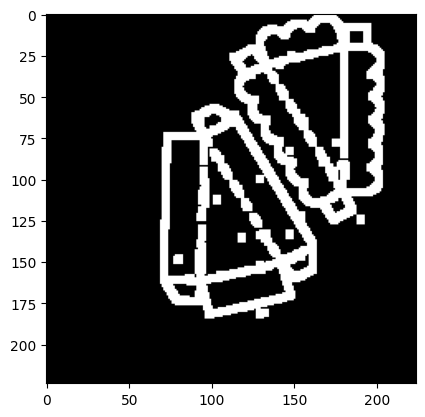

In [6]:
plt.imshow(train_data[20], 'gray')

In [7]:
optimizer = Adam(learning_rate=0.0005) 

In [8]:
# the shape without the batch amount
input_shape = train_data.shape[1:]
# how many output neurons we need to create an image
input_dim = np.prod(input_shape)
encoding_dim = 512
model = Sequential([
              Flatten(), # flatten
                Dense(encoding_dim),
    Dropout(0.4),
              Dense(64), # encode
              Dense(input_dim), # decode
              Reshape(input_shape) # reshape decoding
])

model.compile(optimizer=optimizer, loss='mse') 
early_stopping = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=20,min_delta=0.0001) 
checkpoint = ModelCheckpoint('/content/drive/My Drive/encoder_model.h5', monitor='val_loss', mode='min', save_best_only=True) 
model.fit(train_data, train_data, epochs=1000, batch_size=8,validation_data=(test_data,test_data),callbacks=[early_stopping,checkpoint]) 

Epoch 1/1000
103/103 [==============================] - 4s 21ms/step - loss: 0.2182 - val_loss: 0.1636
Epoch 2/1000
103/103 [==============================] - 2s 18ms/step - loss: 0.1747 - val_loss: 0.1470
Epoch 3/1000
103/103 [==============================] - 2s 17ms/step - loss: 0.1547 - val_loss: 0.1367
Epoch 4/1000
103/103 [==============================] - 2s 17ms/step - loss: 0.1530 - val_loss: 0.1361
Epoch 5/1000
103/103 [==============================] - 1s 12ms/step - loss: 0.1471 - val_loss: 0.1382
Epoch 6/1000
103/103 [==============================] - 1s 12ms/step - loss: 0.1646 - val_loss: 0.1444
Epoch 7/1000
103/103 [==============================] - 1s 12ms/step - loss: 0.1535 - val_loss: 0.1409
Epoch 8/1000
103/103 [==============================] - 2s 18ms/step - loss: 0.1614 - val_loss: 0.1360
Epoch 9/1000
103/103 [==============================] - 2s 18ms/step - loss: 0.1455 - val_loss: 0.1305
Epoch 10/1000
103/103 [==============================] - 2s 18ms/step - l

In [9]:
def plot_(x,y1,y2,row,col,ind,title,xlabel,ylabel,label,isimage=False,color='r'):

    """
    This function is used for plotting images and graphs (Visualization of end results of model training)
    Arguments:
    x - (np.ndarray or list) - an image array
    y1 - (list) - for plotting graph on left side.
    y2 - (list) - for plotting graph on right side.
    row - (int) - row number of subplot
    col - (int) - column number of subplot
    ind - (int) - index number of subplot
    title - (string) - title of the plot 
    xlabel - (list) - labels of x axis
    ylabel - (list) - labels of y axis
    label - (string) - for adding legend in the plot
    isimage - (boolean) - True in case of image else False
    color - (char) - color of the plot (prefered green for training and red for testing).
    """
    
    plt.subplot(row,col,ind)
    if isimage:
        plt.imshow(x)
        plt.title(title)
        plt.axis('off')
    else:
        plt.plot(y1,label=label,color='g'); plt.scatter(x,y1,color='g')
        if y2!='': plt.plot(y2,color=color,label='validation'); plt.scatter(x,y2,color=color)
        plt.grid()
        plt.legend()
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)

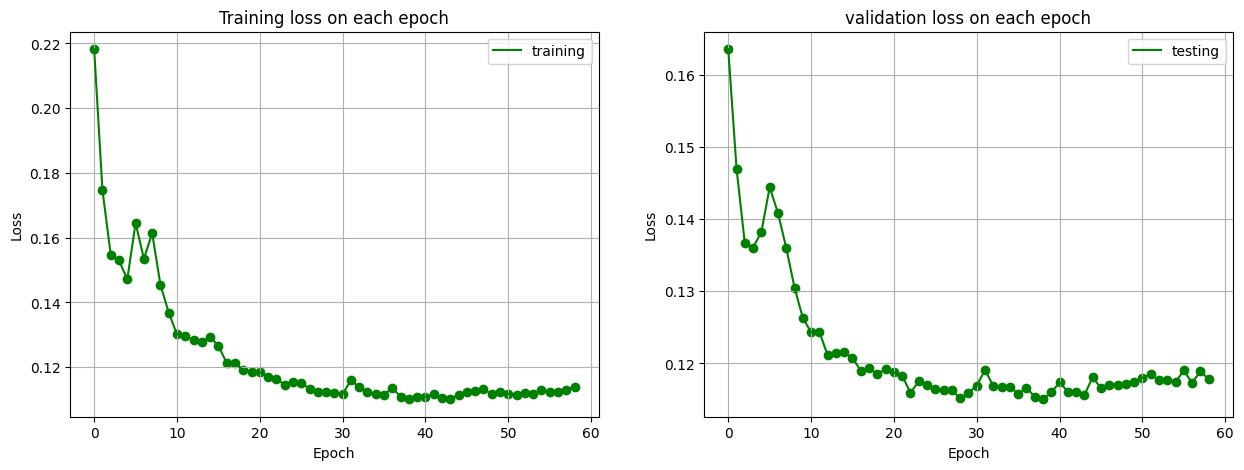

In [10]:
#model.history.history
plt.figure(figsize=(15,5))
epochs = [i for i in range(34)]
plot_(list(range(len(model.history.history["loss"]))),model.history.history["loss"],'',1,2,1,'Training loss on each epoch','Epoch','Loss','training',False,'g')
plot_(list(range(len(model.history.history["loss"]))),model.history.history["val_loss"],'',1,2,2,'validation loss on each epoch','Epoch','Loss','testing',False,'r')

In [9]:
model = load_model("/content/drive/My Drive/encoder_model.h5")
model.compile(optimizer=optimizer, loss='mse') 

In [11]:
sample_image = train_data[200]
sample_image = np.expand_dims(sample_image,axis=0)
image = model.predict(sample_image)

1/1 [==============================] - 0s 121ms/step


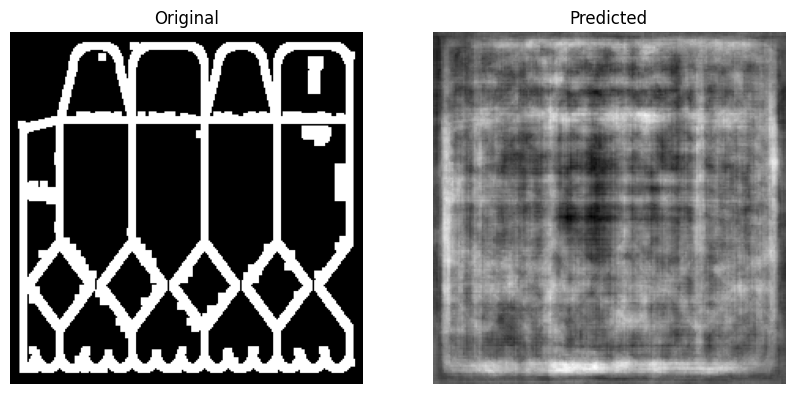

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

ax1.axis("off")
ax1.title.set_text('Original')

ax2.axis("off")
ax2.title.set_text("Predicted")

ax1.imshow(sample_image[0], cmap='gray')
ax2.imshow(image[0], cmap='gray')

In [58]:
img1 = np.array(Image.open("dataset/img/img_6.jpg").convert('L'))
# img = cv2.cvtColor(img, cv2.COLOR_)
img1 = cv2.resize(img1, (224,224))
img1 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    cv2.THRESH_BINARY,11,2)
img1 = 255 - np.array(img1)
kernel = np.ones((5, 5), np.uint8)
img1 = cv2.dilate(img1, kernel)

In [59]:
img2 = np.array(Image.open("dataset/img/img_6_shift_2.jpg").convert('L'))
# img = cv2.cvtColor(img, cv2.COLOR_)
img2 = cv2.resize(img2, (224,224))
img2 = cv2.adaptiveThreshold(img2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
    cv2.THRESH_BINARY,11,2)
img2 = 255 - np.array(img2)
kernel = np.ones((5, 5), np.uint8)
img2 = cv2.dilate(img2, kernel)

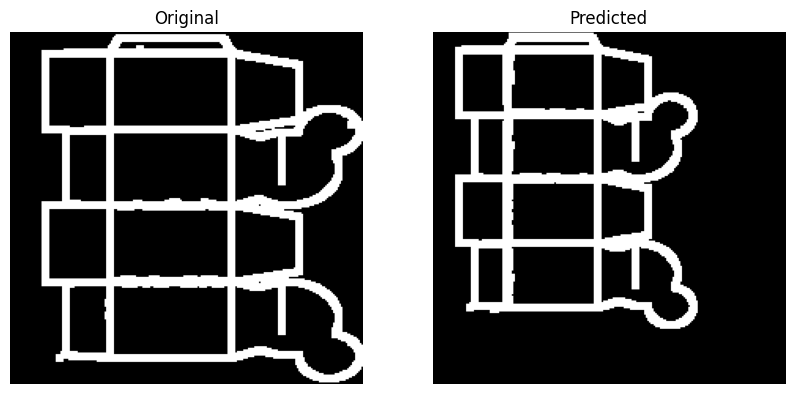

In [60]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

ax1.axis("off")
ax1.title.set_text('Original')

ax2.axis("off")
ax2.title.set_text("Predicted")

ax1.imshow(img1, cmap='gray')
ax2.imshow(img2, cmap='gray')

In [61]:
from keras import backend as K
def feature_extraction(model, data, layer = 3):

    """
    Creating a function to run the initial layers of the encoder model. (to get feature extraction from any layer of the model)
    Arguments:
    model - (Auto encoder model) - Trained model
    data - (np.ndarray) - list of images to get feature extraction from trained model
    layer - (int) - from which layer to take the features(by default = 4)
    Returns:
    pooled_array - (np.ndarray) - array of extracted features of given images
    """

    encoded = K.function([model.layers[0].input],[model.layers[layer].output])
    encoded_array = encoded([data])[0]
    pooled_array = encoded_array.max(axis=-1)
    return encoded_array

In [62]:
img1 = np.expand_dims(img1,axis=0)
encoded1 = feature_extraction(model,img1,3)

In [63]:
img2 = np.expand_dims(img2,axis=0)
encoded2 = feature_extraction(model,img2,3)

In [64]:
np.dot(encoded1[0], encoded2[0]) / (np.linalg.norm(encoded1[0])*np.linalg.norm(encoded2[0]))

0.011899856

In [65]:
encoded1

array([[ 1.61744653e+03,  1.12791785e+03,  7.47343140e+02,
         7.19888672e+02,  2.10053616e+01, -1.04487932e+00,
        -1.85752600e+03, -9.04783401e+01, -1.32854358e+03,
        -1.08102112e+03, -5.60350464e+02, -4.14081696e+02,
         1.45029150e+03,  2.37778076e+02,  6.33820374e+02,
         1.03191382e+03,  6.10119812e+02,  2.47441821e+03,
        -3.38910919e+02,  4.17730011e+02,  2.94829407e+02,
         9.52523438e+02,  2.55888965e+03,  8.73382324e+02,
        -1.04252417e+03, -2.22836841e+03, -9.75424683e+02,
         8.12985779e+02, -1.98994214e+03,  8.28422546e+02,
        -8.70133911e+02, -1.43221448e+03,  1.45029434e+02,
         4.26619049e+02,  1.63807205e+02, -8.50575928e+02,
        -5.92333557e+02, -1.44696274e+02,  3.28715149e+02,
        -5.80727905e+02, -8.29289062e+02, -1.29019067e+03,
         2.40725806e+03,  9.47088928e+02, -1.42354749e+03,
         2.72897217e+02,  5.88463501e+02, -1.64115894e+03,
         1.21295679e+03, -2.93197693e+02,  1.20952966e+0

In [57]:
encoded2

array([[ 1.65033911e+03, -7.86976862e+00,  2.14774582e+02,
         5.45231567e+02, -8.85811386e+01, -7.45404846e+02,
        -1.07312903e+03, -3.98795471e+02,  1.00521844e+03,
        -1.37816699e+03, -6.74223022e+02,  1.86667652e+01,
         1.58842041e+03,  1.56220825e+03, -2.20621384e+02,
         1.11372131e+03, -1.34061804e+03,  1.61806641e+02,
         5.62437439e+01, -7.38404175e+02,  2.74099274e+02,
         1.18071556e+02,  1.53315466e+03,  2.45457993e+02,
         1.86230865e+02, -2.45193091e+03,  1.35209596e+00,
         2.26987183e+03,  8.29244423e+00, -1.72175732e+03,
        -1.34636621e+03,  1.71439355e+03,  5.51082275e+02,
        -3.46358978e+02,  8.19833130e+02, -1.32119678e+03,
         1.01366150e+03,  2.76827942e+02,  8.74332581e+02,
        -1.20500679e+02, -5.76759033e+02, -1.65426544e+02,
         2.40538501e+03,  9.34027222e+02, -3.26574310e+02,
         7.05085510e+02, -4.08255463e+02, -1.55187134e+03,
         8.23936523e+02,  5.94970459e+02,  7.30599442e+0